In [2]:
import pandas as pd
import numpy as np

import scipy
import matplotlib.pyplot as plt
import itertools

import seaborn as sns

In [3]:
df = pd.read_csv('data/tetragonal.csv')

In [4]:
df = df[df.Zr > 0]

In [5]:
dfrt = df[np.abs(df['T'] - 25) < 10]

In [6]:
inputs = ['T']
features = ['en_p', 'ea', 'valence', 'pettifor', 'rad_ionic', 'rad_slater', 'rad_clementi']
outputs = ['a', 'c']

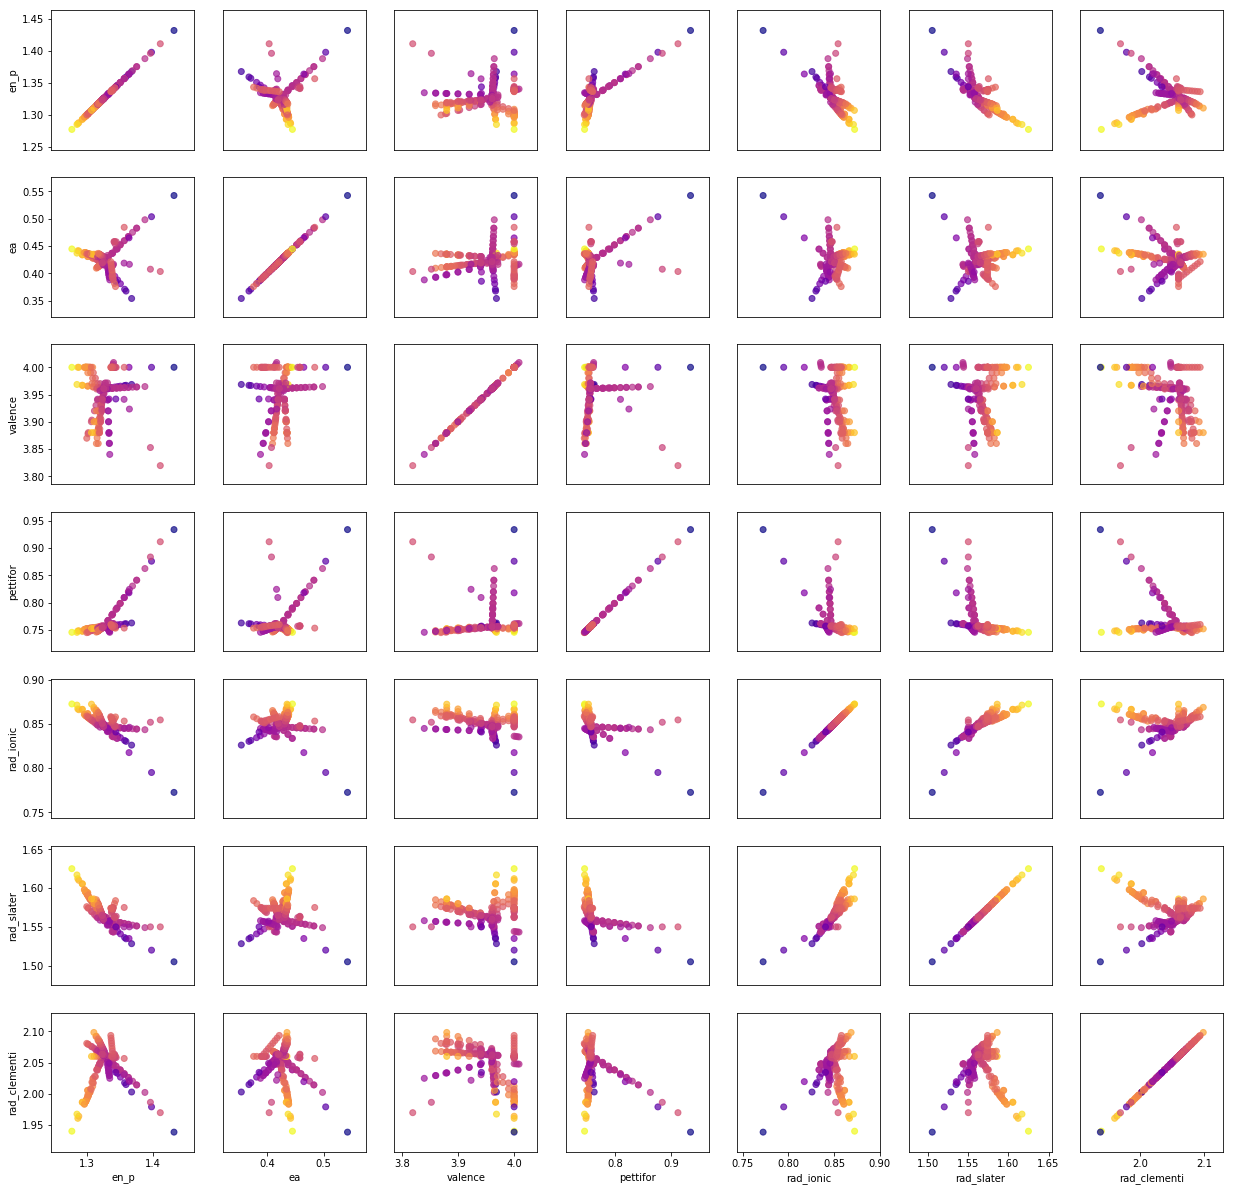

In [61]:
permut = list(itertools.product(features, features))
N = len(features)

fig, ax_fig = plt.subplots(N, N, figsize=(3 * N, 3 * N))

for f1, f2 in permut:
    ix = features.index(f1)
    iy = features.index(f2)
    ax = ax_fig[ix, iy]

    ax.scatter(
        dfrt[f2],
        dfrt[f1],
        c=dfrt['a'],
        cmap='plasma',
        alpha=0.7
    )

    if ix == N-1:
        ax.set_xlabel(f2)
    else:
        ax.set_xticks([], [])
    if iy == 0:
        ax.set_ylabel(f1)
    else:
        ax.set_yticks([], [])
    
fig.savefig('correlations.pdf')
plt.show()

### a vs temperature

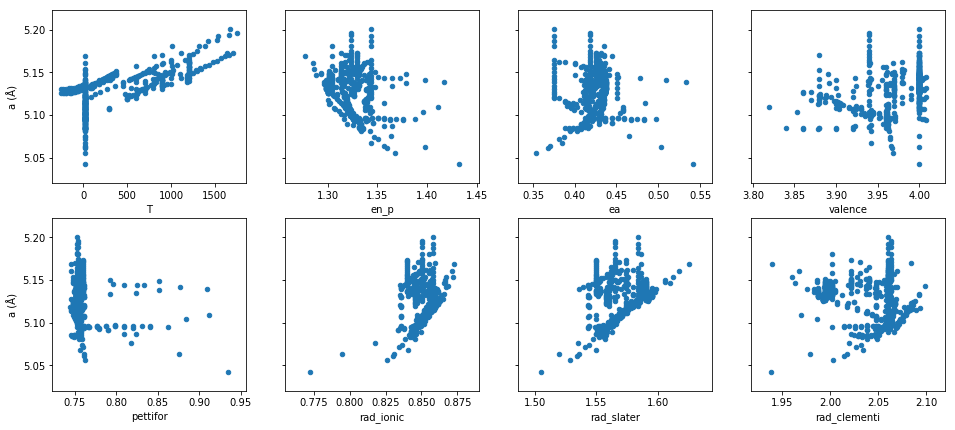

In [13]:
fig, ax_fig = plt.subplots(2, 4, figsize=(16, 7), sharey=True)
for idx, (inp, ax) in enumerate(zip(inputs + features, ax_fig.reshape(-1))):
    df.plot(kind='scatter', x=inp, y='a', ax=ax)
    if idx % 4 == 0:
        ax.set_ylabel('a (Å)')

### Analyzing ea vs rad_slater

In [67]:
data = dfrt[['rad_slater', 'ea', 'a']].values

In [79]:
# regular grid covering the domain of the data
X, Y = np.meshgrid(
    np.linspace(df['rad_slater'].min(), df['rad_slater'].max(), 100),
    np.linspace(df['ea'].min(), df['ea'].max(), 100)
)

XX = X.flatten()
YY = Y.flatten()

order = 2    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

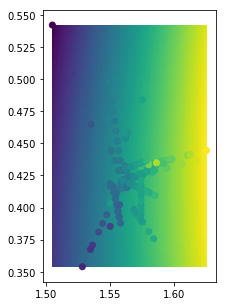

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
                       
ax.imshow(Z, extent=(XX.min(), XX.max(), YY.min(), YY.max()),
           interpolation='nearest', cmap='viridis')

ax.scatter(data[:, 0], data[:, 1], c=data[:, 2])
                       
plt.show()